# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [2]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

C:\Users\m.glazman\AppData\Local\Temp\ipykernel_19784\3634739394.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,Positive
5,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
6,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
7,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative
8,3810,48762,"Pitt Meadows, BC, Canada",16-03-2020,"Due to the Covid-19 situation, we have increas...",Extremely Positive
9,3811,48763,Horningsea,16-03-2020,#horningsea is a caring community. LetÃÂs AL...,Extremely Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [4]:
def corrected_sentiment (sentiment: str):
    if 'Positive' in sentiment: return 1
    else: return 0

df['Sentiment'] = df['Sentiment'].map(corrected_sentiment, na_action = 'ignore')
df.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1
5,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,1
6,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,1
7,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",0
8,3810,48762,"Pitt Meadows, BC, Canada",16-03-2020,"Due to the Covid-19 situation, we have increas...",1
9,3811,48763,Horningsea,16-03-2020,#horningsea is a caring community. LetÃÂs AL...,1


Сбалансированы ли классы?

In [5]:
balance = df['Sentiment'].value_counts()
balance_2 = balance/balance.sum()
balance_2

Sentiment
1    0.539589
0    0.460411
Name: count, dtype: float64

**Ответ:** Доли отличаются менее чем на 10%, можно говорить что классы сбалансированы

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [6]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [7]:
df.fillna('Unknown', inplace=True)

In [8]:
df.isnull().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [10]:
d = dict()
for i in train['OriginalTweet']:
    tokens = i.split(' ')
    tokens = [token.lower() for token in tokens]
    for j in tokens:
        if j in d:  d[j] += 1
        else:   d[j] = 1
d

{'why': 624,
 'we': 3655,
 'still': 758,
 'want': 485,
 'to': 23338,
 'buy': 733,
 'so': 1800,
 'much': 482,
 'stuff': 105,
 'during': 1900,
 'quarantine': 150,
 'https://t.co/1m881cwfuv': 1,
 '#shopping': 113,
 '#covid_19': 1383,
 '#online': 40,
 'with': 4039,
 'driving': 76,
 'even': 667,
 'more': 1967,
 'usage': 22,
 'a': 11668,
 'strong': 91,
 'strategy': 32,
 'is': 7361,
 'critical': 155,
 'now': 1308,
 'then': 425,
 'ever': 177,
 'luckily': 8,
 'and': 14595,
 'april': 158,
 '16': 35,
 'webinar': 65,
 'will': 2710,
 'dive': 10,
 'into': 666,
 'growing': 83,
 'app': 51,
 'awareness': 32,
 'targeting': 9,
 'high': 406,
 'lifetime': 4,
 'value': 79,
 'users': 18,
 '@canon_india': 15,
 'i': 5156,
 'am': 418,
 'very': 415,
 'happy..': 1,
 'great': 406,
 'job': 240,
 'by': 2217,
 '#canonforcommunity\r\r\nhttps://t.co/z0intks34x': 1,
 'the': 26597,
 'u.s': 8,
 'national': 123,
 'debt': 67,
 'likely': 170,
 'exceed': 14,
 '$30': 7,
 'trillion': 21,
 'after': 875,
 'unprecedented': 89,
 'b

Какой размер словаря получился?

In [11]:
print('Размер словаря:', len(d), 'слов')

Размер словаря: 84745 слов


Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [12]:
top_ten = sorted(d.items(), key = lambda x:x[1], reverse=True)[:10]
top_ten

[('the', 26597),
 ('to', 23338),
 ('and', 14595),
 ('of', 13006),
 ('a', 11668),
 ('in', 11127),
 ('for', 8519),
 ('', 7531),
 ('is', 7361),
 ('#coronavirus', 7132)]

**Ответ:** Почти все эти слова - предлоги и частицы, не несущие смысловой нагрузки, но встречающиейся в каждом предложении (просто из-за структуры языка). Так же в топе есть #coronavirus, потому что твиты посвящены этой теме и скорее всего ищутся именно по этому хэштэгу.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [13]:
import nltk
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords

new_dict = dict()
for i,j in d.items():
    if i not in stopwords.words("english"): new_dict[i] = j
    
top_ten = sorted(new_dict.items(), key = lambda x:x[1], reverse=True)[:10]
top_ten

[('', 7531),
 ('#coronavirus', 7132),
 ('prices', 3817),
 ('food', 3780),
 ('grocery', 3424),
 ('supermarket', 3249),
 ('store', 3133),
 ('people', 3124),
 ('covid-19', 3086),
 ('&amp;', 2304)]

**Ответ:** Ну первое, что хочется заметить - на первом месте пустой символ - скорее всего человек просто прожал 2 пробела. Но большая часть слов совпадаем с тематикой, также есть слово &amp, которое должно быть несколькими словами. Таким образом, данный вид токенизации не лочень подходит для твитов, но больша часть слов оделилась так, как нужно

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [14]:
last_twenty = sorted(new_dict.items(), key = lambda x:x[1], reverse=False)[:20]
last_twenty

[('https://t.co/1m881cwfuv', 1),
 ('happy..', 1),
 ('#canonforcommunity\r\r\nhttps://t.co/z0intks34x', 1),
 ('mnuchinã\x82â\x92s', 1),
 ('brink.', 1),
 ('https://t.co/jmobv8z0u0', 1),
 ("university's", 1),
 ('teaching.)', 1),
 ('@catholicpres', 1),
 ('@catholicuniv', 1),
 ('https://t.co/evqby035wf', 1),
 ('https://t.co/riqrhxxeim', 1),
 ('@@ballardspahrll', 1),
 ('#aca', 1),
 ('easier...take', 1),
 ('ã\x82â\x93necessaryã\x82â\x94', 1),
 ('https://t.co/0fmsmlgepm', 1),
 ('husted:', 1),
 ('irishman', 1),
 ('#happystpatricksday!\r\r\n\r\r\nat', 1)]

**Ответ:** Почти все слова тут сформированы опечатками и использованием сторонних символов. Это еще один недостаток сплита по пробелам



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [15]:
from nltk.tokenize import TweetTokenizer
tw = TweetTokenizer()
d_tweets = dict()
for i in train['OriginalTweet']:
    tokens = tw.tokenize(i)
    tokens = [token.lower() for token in tokens]
    for j in tokens:
        if j in d_tweets:  d_tweets[j] += 1
        else:   d_tweets[j] = 1
top_ten = sorted(d_tweets.items(), key = lambda x:x[1], reverse=True)[:10]
top_ten        


[('the', 26993),
 ('.', 24118),
 ('to', 23478),
 (',', 17571),
 ('and', 14825),
 ('of', 13044),
 ('a', 11891),
 ('in', 11348),
 ('?', 9524),
 ('#coronavirus', 8808)]

**Ответ:** В нем много пунктационных знаков

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [16]:
from string import punctuation

noise = stopwords.words("english") + list(punctuation)
d_tweets_new = dict()
for i,j in d_tweets.items():
    if i not in noise: d_tweets_new[i] = j
    
top_ten = sorted(d_tweets_new.items(), key = lambda x:x[1], reverse=True)[:10]
top_ten

[('#coronavirus', 8808),
 ('â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('\x92', 4372),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805)]

**Ответ:** Да, слова начинающиеся со \ и странная буква а

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [17]:
filtered_dict = [(i, j) for i, j in d_tweets_new.items() if len(i) > 1 or ord(i) < 128]
top_ten = sorted(filtered_dict, key = lambda x:x[1], reverse=True)[:10]
top_ten

[('#coronavirus', 8808),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805),
 ('grocery', 3523),
 ('people', 3463),
 ('#covid19', 2589)]

**Ответ:** Этот топ состоит из слов по тематике COVID-19 и в нем только "нормальные слова"

In [18]:
filtered_dict = [(i, j) for i, j in d_tweets_new.items() if len(i) > 1 or ord(i) < 128]
tweets_dict = dict(filtered_dict)
last_twenty = sorted(filtered_dict, key = lambda x:x[1], reverse=False)[:20]
last_twenty

[('https://t.co/1m881cwfuv', 1),
 ('https://t.co/z0intks34x', 1),
 ('mnuchinã', 1),
 ('https://t.co/jmobv8z0u0', 1),
 ("university's", 1),
 ('@catholicpres', 1),
 ('@catholicuniv', 1),
 ('https://t.co/evqby035wf', 1),
 ('https://t.co/riqrhxxeim', 1),
 ('@ballardspahrll', 1),
 ('#aca', 1),
 ('https://t.co/0fmsmlgepm', 1),
 ('irishman', 1),
 ('#happystpatricksday', 1),
 ('guiness', 1),
 ('https://t.co/18v0pyhwb7', 1),
 ('https://t.co/ls0g86i8pu', 1),
 ('https://t.co/ofvkejff23', 1),
 ('https://t.co/xoodgd2ulx', 1),
 ('lifestyles', 1)]

В этом топе в основном ссылки и слова с опечатками/ошибками

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [19]:
tegs = [(i, j) for i,j in tweets_dict.items() if '#' in i]
top_ten_tegs = sorted(tegs, key = lambda x: x[1], reverse = True)[:10]
top_ten_tegs

[('#coronavirus', 8808),
 ('#covid19', 2589),
 ('#covid_19', 1734),
 ('#covid2019', 946),
 ('#toiletpaper', 744),
 ('#covid', 641),
 ('#socialdistancing', 465),
 ('#coronacrisis', 448),
 ('#pandemic', 257),
 ('#coronaviruspandemic', 249)]

**Ответ:** Все хэштэги связаны с covid-19, есть предположение, что по ним и отбирались твиты в датасет

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [20]:
links = [(i, j) for i,j in tweets_dict.items() if 'https://t.co' in i]
top_ten_links = sorted(links, key = lambda x: x[1], reverse = True)[:10]
top_ten_links

[('https://t.co/oxa7swtond', 5),
 ('https://t.co/gp3eusapl8', 4),
 ('https://t.co/deftrui1pfã\x82â', 3),
 ('https://t.co/wrlhyzizaa', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/zjnrx6dkkn', 3),
 ('https://t.co/3gbbdpdjat', 3),
 ('https://t.co/e2znxajpre', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/g63rp042ho', 3)]

**Ответ:** Нет, т.к. судя по данным, люди приврепляют ссылки на разные страницы

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [21]:
def custom_tokenizer(text):
    text = text.encode().decode('unicode-escape') # Без этого выдавало ошибку компиляции
    our = [i.lower() for i in text]
    noise = set(stopwords.words("english") + list(punctuation))
    tw = TweetTokenizer()
    tokens_start = tw.tokenize(''.join(our))
    tokens = []
    for i in tokens_start:
        if i not in noise and 'https://t.co' not in i and len(i) > 1:
            tokens.append(i)
        if i not in noise and len(i) == 1 and ord(i) < 128:
          tokens.append(i)
    return tokens


In [22]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer(tokenizer = custom_tokenizer)
X = cnt_vec.fit_transform(train['OriginalTweet'])
X.shape

c:\Python\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\m.glazman\AppData\Local\Temp\ipykernel_19784\2364570482.py:2: DeprecationWarning: invalid escape sequence '\h'
  text = text.encode().decode('unicode-escape') # Без этого выдавало ошибку компиляции


(23410, 45308)

**Ответ:** В нем стало меньше слов засчет использвания токенизации (слова - колонки X), т.к. мы удаляем слова, не несущие смысловой нагрузки и ссылки

Посмотрим на какой-нибудь конкретный твитт:

In [24]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [25]:
example = pd.DataFrame(X[ind].toarray(), columns = cnt_vec.get_feature_names_out())
summa = example.sum(axis = 0)
summa.loc[summa >= 1].sort_values()

#coronavirusoutbreak    1
#covid2019              1
@skynews                1
brainless               1
ffs                     1
food                    1
france                  1
lets                    1
nice                    1
one                     1
panic                   1
ppl                     1
queueing                1
show                    1
dtype: int64

**Ответ:** Сложно определить потому что частота каждого слова от 0 до 1 раза

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(tokenizer = custom_tokenizer)
X = tfidf_vec.fit_transform(train['OriginalTweet'])
X.shape

c:\Python\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\m.glazman\AppData\Local\Temp\ipykernel_19784\2364570482.py:2: DeprecationWarning: invalid escape sequence '\h'
  text = text.encode().decode('unicode-escape') # Без этого выдавало ошибку компиляции


(23410, 45308)

In [27]:
example = pd.DataFrame(X[ind].toarray(), columns = tfidf_vec.get_feature_names_out())
sum_new = example.sum()
sum_new.loc[sum_new != 0.0].sort_values()


food                    0.113289
panic                   0.147595
one                     0.163067
#covid2019              0.168252
#coronavirusoutbreak    0.225843
show                    0.244065
nice                    0.254273
ppl                     0.255006
lets                    0.301211
@skynews                0.310426
france                  0.320473
ffs                     0.324474
queueing                0.354346
brainless               0.386764
dtype: float64

**Ответ:** Такая сортировка более полезна, потому что в ней больший вес имеют более редкие/более важные слова лучше описывающие мнение автора. Однако например такие важные слова как "panic" наш векторайзер посчитал менее важными.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [28]:
train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4583,9362,54314,"Moulton, England",19-03-2020,Hearing so many stories of NHS heroes Teachers...,1
8221,13787,58739,Unknown,20-03-2020,Let s just take a minute to say THANK YOU also...,1
3183,7654,52606,"London, England",18-03-2020,"Back at the ""Frontline""\r\r\nA massive shout o...",1
24347,33577,78529,Unknown,05-04-2020,Massive thanks to @waitrose for my delivery of...,1
3281,7772,52724,"Nairobi, Kenya",18-03-2020,Crisp clean fresh air perfect ambience Covid 1...,1
...,...,...,...,...,...,...
8199,13757,58709,Wrightington,20-03-2020,The support from customers this week has been ...,1
11636,17911,62863,Australia,21-03-2020,"Margot Robbie is an amazing actress, and love ...",1
23018,31918,76870,"Karachi, Pakistan",04-04-2020,Face Mask (Pack of 5) ÃÂ Meeting the need of...,1
5208,10126,55078,Unknown,19-03-2020,There's some amazing work going on in the worl...,1


In [29]:
ind = 8199
example = pd.DataFrame(X[ind].toarray(), columns = tfidf_vec.get_feature_names_out())
sum_new = example.sum()
sum_new.loc[sum_new != 0.0].sort_values()

#coronavirus    0.077315
prices          0.104830
pandemic        0.144799
stock           0.157974
global          0.195118
around          0.197084
look            0.203432
result          0.233636
story           0.233636
major           0.235392
growth          0.256262
expectations    0.282853
built           0.318580
regions         0.328379
@refinitiv      0.368525
#earnings       0.404252
dtype: float64

**Ответ:** По наиболее важным словам видно, что текст посвящен экономическому росту и положительно окрашен

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [30]:
cnt_vec = CountVectorizer(tokenizer = custom_tokenizer)
X_vec = cnt_vec.fit_transform(train['OriginalTweet'])
tfidf_vec = TfidfVectorizer(tokenizer = custom_tokenizer)
X_tfidf = tfidf_vec.fit_transform(train['OriginalTweet'])

c:\Python\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\m.glazman\AppData\Local\Temp\ipykernel_19784\2364570482.py:2: DeprecationWarning: invalid escape sequence '\h'
  text = text.encode().decode('unicode-escape') # Без этого выдавало ошибку компиляции


In [31]:
X_vec.shape

(23410, 45308)

In [32]:
X_tfidf.shape

(23410, 45308)

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Сначала на CountVectorizer

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train = cnt_vec.fit_transform(train['OriginalTweet'])
y_train = train['Sentiment']
X_test = cnt_vec.transform(test['OriginalTweet'])
y_test = test['Sentiment']
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

C:\Users\m.glazman\AppData\Local\Temp\ipykernel_19784\2364570482.py:2: DeprecationWarning: invalid escape sequence '\h'
  text = text.encode().decode('unicode-escape') # Без этого выдавало ошибку компиляции
C:\Users\m.glazman\AppData\Local\Temp\ipykernel_19784\2364570482.py:2: DeprecationWarning: invalid escape sequence '\i'
  text = text.encode().decode('unicode-escape') # Без этого выдавало ошибку компиляции


In [34]:
accuracy_score(y_test, y_pred_lr)

0.8684472792505481

Теперь TfidfVectorizer

In [35]:
X_train = tfidf_vec.fit_transform(train['OriginalTweet'])
y_train = train['Sentiment']
X_test = tfidf_vec.transform(test['OriginalTweet'])
y_test = test['Sentiment']
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

c:\Python\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\m.glazman\AppData\Local\Temp\ipykernel_19784\2364570482.py:2: DeprecationWarning: invalid escape sequence '\h'
  text = text.encode().decode('unicode-escape') # Без этого выдавало ошибку компиляции
C:\Users\m.glazman\AppData\Local\Temp\ipykernel_19784\2364570482.py:2: DeprecationWarning: invalid escape sequence '\i'
  text = text.encode().decode('unicode-escape') # Без этого выдавало ошибку компиляции


In [36]:
accuracy_score(y_test, y_pred_lr)

0.8534981064381104

**Ответ:** CountVectorizer показал себя немного лучше. Возможно это связано с тем, что слова негативной и позитивной окраски часто попадают в конец списка, т.к. используются довольно часто

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [37]:
from nltk.stem.snowball import SnowballStemmer
def custom_stem_tokenizer(text):
  tokens = custom_tokenizer(text)
  stemmer = SnowballStemmer("english")
  stemmed_tokens = {stemmer.stem(i) for i in tokens}
  return stemmed_tokens

In [38]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

{'#sampletext', '@sample_text', 'ad', 'check', 'sampl', 'stem', 'text', 'word'}

In [39]:
cv = CountVectorizer(tokenizer = custom_stem_tokenizer)
X_train = cv.fit_transform(train['OriginalTweet'])
y_train = train['Sentiment']
X_test = cv.transform(test['OriginalTweet'])
t_test = test['Sentiment']
print(len(cv.vocabulary_))

c:\Python\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\m.glazman\AppData\Local\Temp\ipykernel_19784\2364570482.py:2: DeprecationWarning: invalid escape sequence '\h'
  text = text.encode().decode('unicode-escape') # Без этого выдавало ошибку компиляции
C:\Users\m.glazman\AppData\Local\Temp\ipykernel_19784\2364570482.py:2: DeprecationWarning: invalid escape sequence '\i'
  text = text.encode().decode('unicode-escape') # Без этого выдавало ошибку компиляции


36652


**Ответ** Словарь уменьшился, потому что разные формы одного слова теперь не считаются разными словами

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [40]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [41]:
accuracy_score(y_test, y_pred_lr)

0.8650588000797289

In [42]:
tfidf = TfidfVectorizer(tokenizer = custom_stem_tokenizer)
X_train = tfidf.fit_transform(train['OriginalTweet'])
X_test = tfidf.transform(test['OriginalTweet'])

c:\Python\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\m.glazman\AppData\Local\Temp\ipykernel_19784\2364570482.py:2: DeprecationWarning: invalid escape sequence '\h'
  text = text.encode().decode('unicode-escape') # Без этого выдавало ошибку компиляции
C:\Users\m.glazman\AppData\Local\Temp\ipykernel_19784\2364570482.py:2: DeprecationWarning: invalid escape sequence '\i'
  text = text.encode().decode('unicode-escape') # Без этого выдавало ошибку компиляции


In [43]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [44]:
accuracy_score(y_test, y_pred_lr)

0.8566872633047639

**Ответ:** #Скор почти не изменился в обоих случаях, стемминг в данном случае не очень эффективен

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [45]:
X = cv.fit_transform(train['OriginalTweet'])

c:\Python\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\m.glazman\AppData\Local\Temp\ipykernel_19784\2364570482.py:2: DeprecationWarning: invalid escape sequence '\h'
  text = text.encode().decode('unicode-escape') # Без этого выдавало ошибку компиляции


In [46]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df = X.toarray().sum(axis = 0).max()-1
                        ).fit(train['OriginalTweet'])
print(len(cv_df.vocabulary_))

C:\Users\m.glazman\AppData\Local\Temp\ipykernel_19784\2364570482.py:2: DeprecationWarning: invalid escape sequence '\h'
  text = text.encode().decode('unicode-escape') # Без этого выдавало ошибку компиляции


36651


**Ответ:** ну он очень большой, т.к. нужно отсекать только наибольшую частоту

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [47]:
min_df = np.sort(X.toarray().sum(axis = 0))
ind = 36652 - 3700
min_df[ind]

10

In [48]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df = 11
                        ).fit(train['OriginalTweet'])
print(len(cv_df.vocabulary_))

C:\Users\m.glazman\AppData\Local\Temp\ipykernel_19784\2364570482.py:2: DeprecationWarning: invalid escape sequence '\h'
  text = text.encode().decode('unicode-escape') # Без этого выдавало ошибку компиляции


3699


**Ответ:** Получилось подобрать частоту только для 3699 элементов(далее идут слова с одинаковой частотой = 10). Хочется отметить, что в словаре около 90% слов встречались 10 и менее раз

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [49]:
from sklearn.preprocessing import StandardScaler
np.random.seed(25)
y_train = train['Sentiment']
y_test = test['Sentiment']
X_train = cv_df.fit_transform(train['OriginalTweet'])
scaler = StandardScaler()
x_train_norm = pd.DataFrame(data = scaler.fit_transform(X_train.toarray()))
X_test = cv_df.transform(test['OriginalTweet'])
x_test_norm  = pd.DataFrame(data = scaler.fit_transform(X_test.toarray()))

C:\Users\m.glazman\AppData\Local\Temp\ipykernel_19784\2364570482.py:2: DeprecationWarning: invalid escape sequence '\h'
  text = text.encode().decode('unicode-escape') # Без этого выдавало ошибку компиляции
C:\Users\m.glazman\AppData\Local\Temp\ipykernel_19784\2364570482.py:2: DeprecationWarning: invalid escape sequence '\i'
  text = text.encode().decode('unicode-escape') # Без этого выдавало ошибку компиляции


In [50]:
lr = LogisticRegression()
lr.fit(x_train_norm, y_train)
y_pred_lr = lr.predict(x_test_norm)

In [51]:
accuracy_score(y_test, y_pred_lr)

0.8416384293402431

In [52]:
lr.coef_[0]

array([-0.01957672,  0.01883107,  0.04374616, ...,  0.00478728,
       -0.00409783, -0.02248414])

In [53]:
cv_df.get_feature_names_out()

array(['#2020', '#21daylockdown', '#21dayslockdown', ..., 'zombi', 'zone',
       'zoom'], dtype=object)

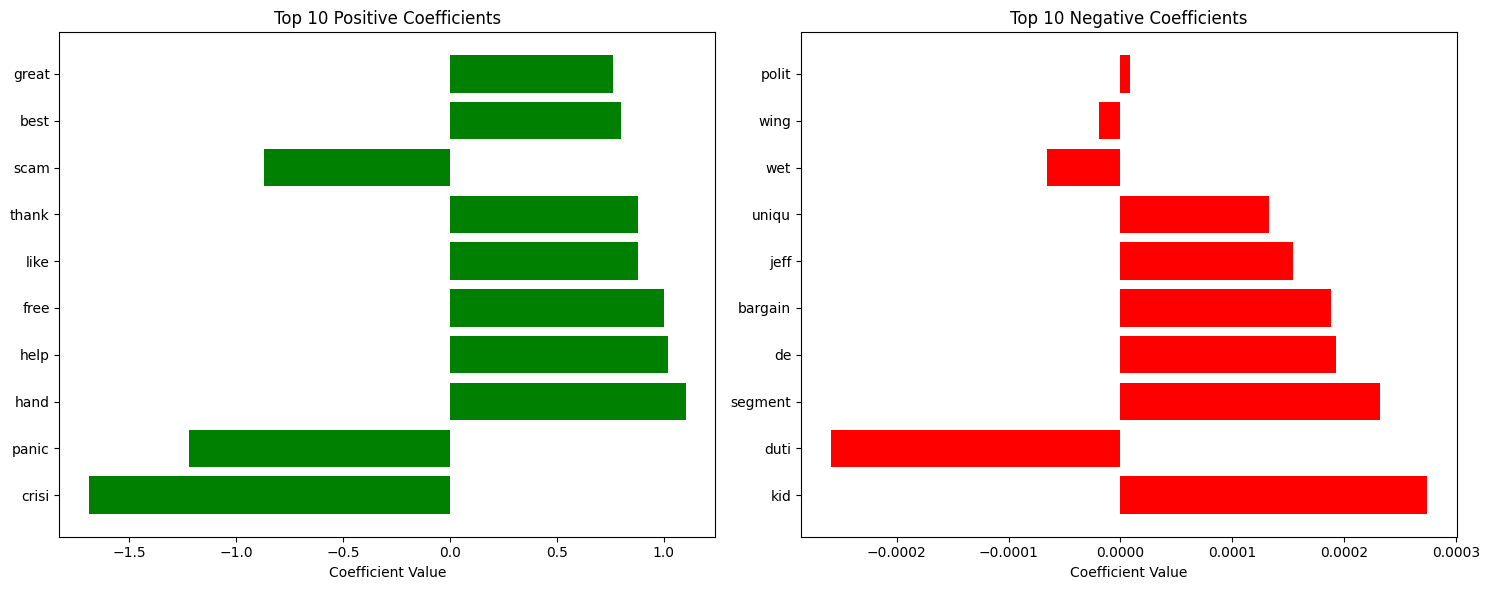

In [54]:
import matplotlib.pyplot as plt

coefficients = lr.coef_[0]
#создаем датафрэйм коэффициентов где строка: токен - его вес
coefficients_df = pd.DataFrame({'Token': cv_df.get_feature_names_out(), 'Coefficient': coefficients})

#сортируем по модулю веса
coefficients_df['Abs_Coefficient'] = coefficients_df['Coefficient'].abs()
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

#два отедльных df для графика
top_positive = coefficients_df.head(10)
top_negative = coefficients_df.tail(10)

#сроим barplot по полученным ранее датасетам top_positive и top-negative
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.barh(top_positive['Token'], top_positive['Coefficient'], color='green')
plt.xlabel('Coefficient')
plt.title('Top 10 Positive Tokens')

plt.subplot(1, 2, 2)
plt.barh(top_negative['Token'], top_negative['Coefficient'], color='red')
plt.xlabel('Coefficient')
plt.title('Top 10 Negative Tokens')

plt.tight_layout()
plt.show()

**Ответ:** Наибольшими значениями обладают токены, несущие эмоциональный окрас, наименьшими - обычные часто-встречающиеся слова. Это и логично, т.к. по "зеленым" токенам намного больше можно сказать о настроении твита (я примерно их и использовал для поиска хороших/плохих)

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [56]:
train[['UserName', 'ScreenName', 'Sentiment']].head(10)

,UserName,ScreenName,Sentiment
25621,35178,80130,1
30135,40819,85771,1
28899,39249,84201,1
5989,11068,56020,0
4367,9109,54061,1
21350,29840,74792,1
15378,22516,67468,1
26258,35962,80914,0
11184,17370,62322,1
5104,10001,54953,0


**Ответ:** Я повыводил разные части df тут вроде и без графиков понятно что они не нужны. Да и концептуально от устройства и id user его отношение к covid-19 врядли зависит

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [58]:
train['TweetAt']

25621    06-04-2020
30135    10-04-2020
28899    09-04-2020
5989     19-03-2020
4367     18-03-2020
            ...    
20757    31-03-2020
32103    13-04-2020
30403    10-04-2020
21243    01-04-2020
2732     18-03-2020
Name: TweetAt, Length: 23410, dtype: object

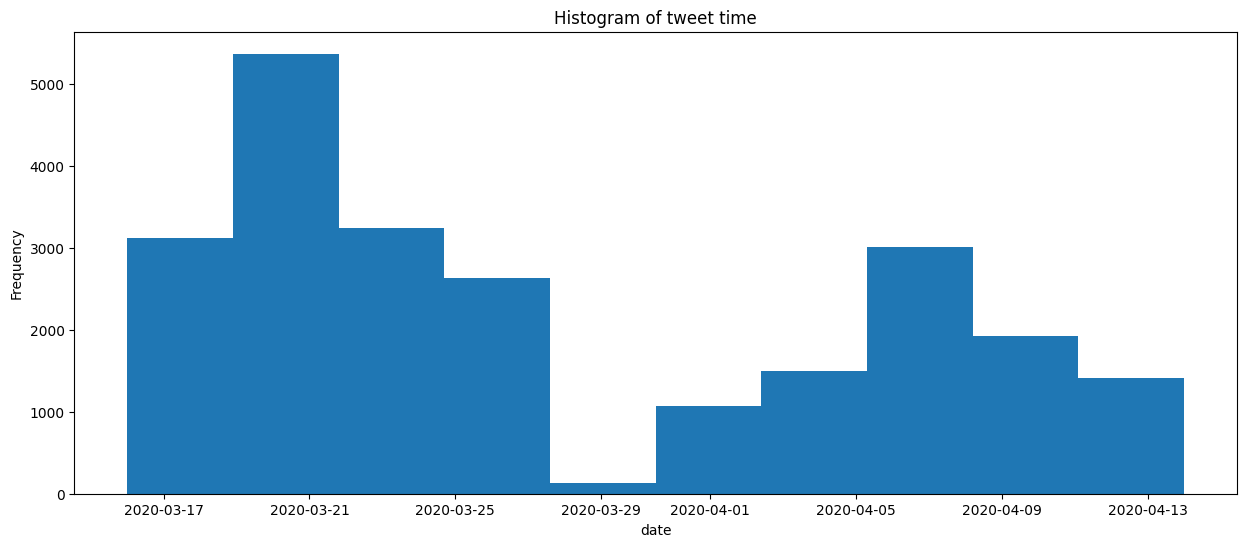

In [77]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format = '%d-%m-%Y')
plt.figure(figsize = (15, 6))
plt.hist(train['TweetAt'], bins = 10)
plt.title('Histogram of tweet time')
plt.xlabel('date')
plt.ylabel('Frequency')
plt.show()

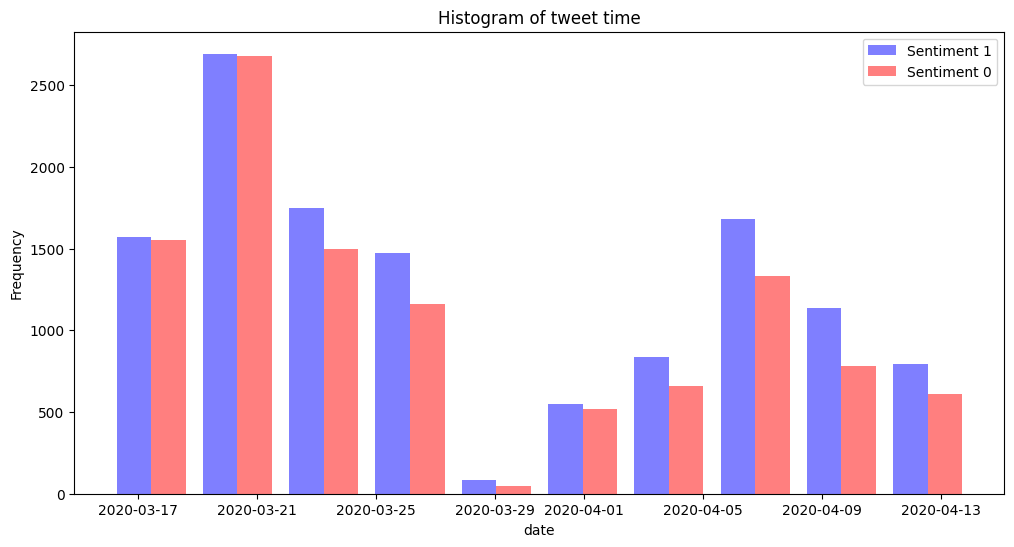

In [82]:
positive = train[train['Sentiment'] == 1]['TweetAt']
negative = train[train['Sentiment'] == 0]['TweetAt']

plt.figure(figsize=(12, 6))

#просто создаем 2 гистограммы на одном графике с раскраской в зависимости от sentiment
plt.hist([positive, negative], bins=10, alpha=0.5, label=['Sentiment 1', 'Sentiment 0'], color=['blue', 'red'])

plt.title('Histogram of tweet time')
plt.xlabel('date')
plt.ylabel('Frequency')
plt.legend()
plt.show()


**Ответ:** Как видно в зависимости от даты доля положительных/отрицательных твитов не отличается => он не имеет смысла



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [118]:
train['Location'].nunique()

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

In [119]:
top_10 = train['Location'].value_counts().sort_values(ascending = False)[1:11]

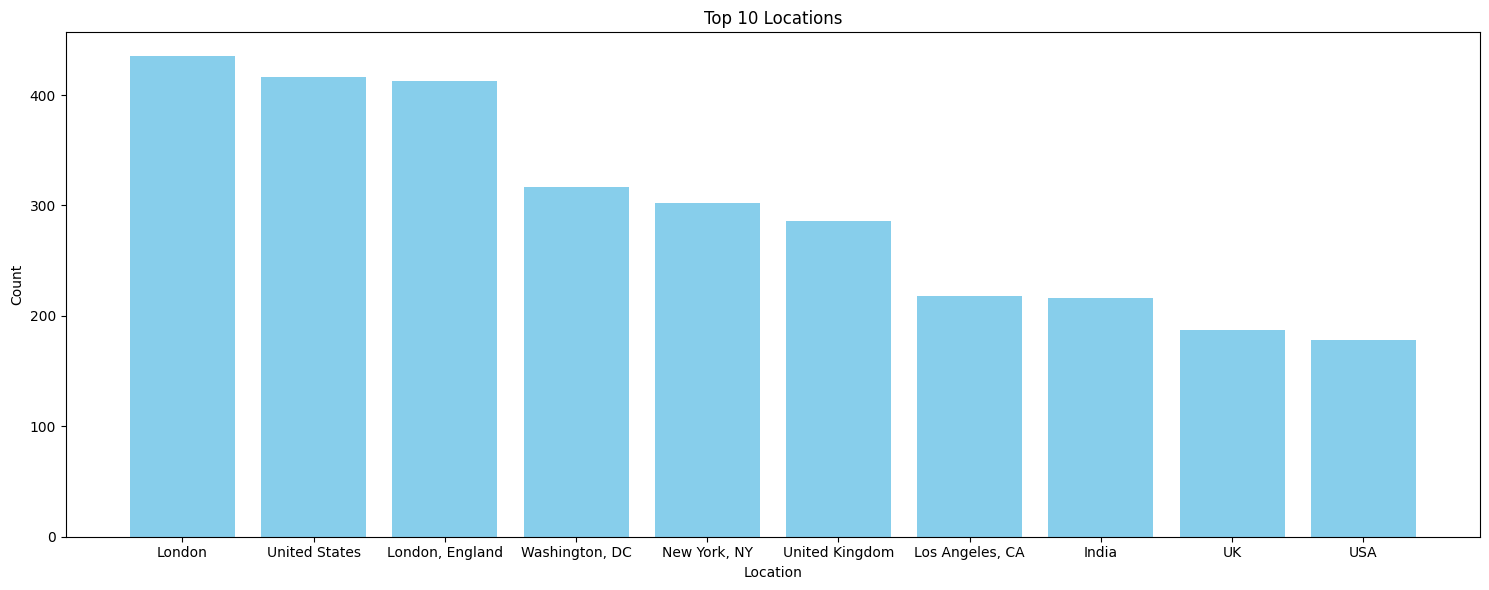

In [115]:
plt.figure(figsize=(15, 6))

plt.bar(top_10.index, top_10.values, color='skyblue')
plt.title('Top 10 Locations')
plt.xlabel('Location')
plt.ylabel('Count')

#для лучшей читаемости
plt.tight_layout()

plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [116]:
def get_wider_location(location):
    location_list = location.split(', ')
    if len(location_list) > 1: return location_list[-1]  
    else: return location

train['WiderLocation'] = train['Location'].apply(get_wider_location)

In [117]:
train['WiderLocation'].nunique()

4921

In [120]:
top_10 =train ['WiderLocation'].value_counts().sort_values(ascending = False)[1:11]

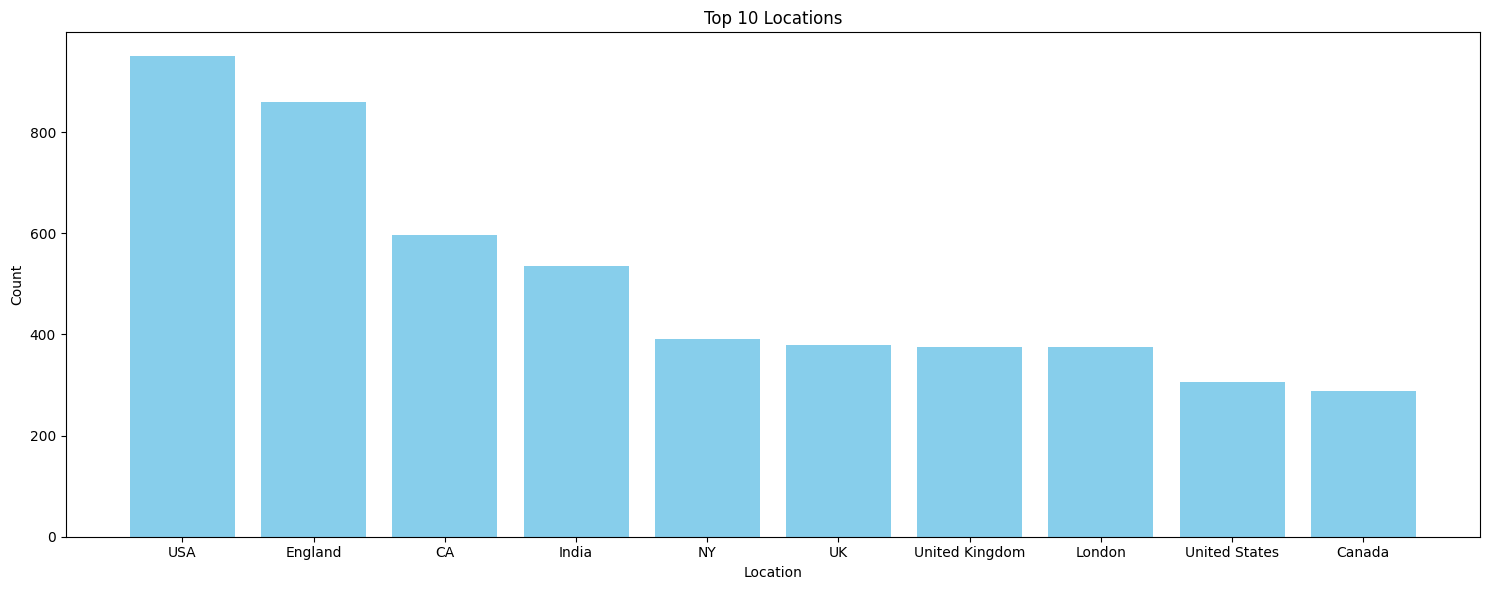

In [121]:
plt.figure(figsize=(15, 6))

plt.bar(top_10.index, top_10.values, color='skyblue')
plt.title('Top 10 Locations')
plt.xlabel('Location')
plt.ylabel('Count')

#для лучшей читаемости
plt.tight_layout()

plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [130]:
# Отбор местоположений, которые встречаются более одного раза
frequent_locations = train['WiderLocation'].value_counts()[train['WiderLocation'].value_counts() > 1].index.tolist()

#Применяем OHE
ohe = pd.get_dummies(train['WiderLocation'][train['WiderLocation'].isin(frequent_locations)])

len(ohe.columns)

1010

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

**Ответ:** Я пытался, у меня не получилось(

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)